<a href="https://colab.research.google.com/github/mirandajosee/ConvolutionalNeuralNetwork-FashionMNIST/blob/main/Conjuntos_de_datos_de_entrenamiento%2C_validaci%C3%B3n_y_prueba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import sklearn as skl
import pandas as pd
#from torchviz import make_dot
import torch.optim as optim
from collections import defaultdict
import pickle
import dill
import json
import datetime
try:
    import google.colab
    from google.colab import files  
    COLAB = True
except:
    COLAB = False

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Usando el dispositivo {}'.format(device))

Usando el dispositivo cpu


In [ ]:
# La primera vez esto tarda un rato ya que tiene que bajar los datos de la red.

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

train_dataset_all = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
# Dividimos el dataset de entrenamiento en 60 partes de 1000 muestras.
num_split = 60
size_split = len(train_dataset_all)/num_split
train_dataset_split = random_split(train_dataset_all,int(num_split-1)*[int(size_split)]+[len(train_dataset_all)-int(num_split-1)*int(size_split)])
split_idxs = np.arange(num_split)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
class Net(nn.Module):
    def __init__(self,n=128):
        super(Net,self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(28*28,n)
        self.linear2 = nn.Linear(n,n)
        self.linear3 = nn.Linear(n,10)
    def forward(self,x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

In [ ]:
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer,verbose_each=32):  
    # Calculamos cosas utiles que necesitamos
    num_samples = len(dataloader.dataset)
    # Seteamos el modelo en modo entrenamiento. Esto sirve para activar, por ejemplo, dropout, etc. durante la fase de entrenamiento.
    model.train()
    # Pasamos el modelo la GPU si está disponible.        
    model = model.to(device)    
    # Iteramos sobre lotes (batchs)
    for batch,(X,y) in enumerate(dataloader):
        # Pasamos los tensores a la GPU si está disponible.
        X = X.to(device)
        y = y.to(device)      
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso cada 100 batchs
        if batch % verbose_each*len(X) == 0:
            loss   = loss.item()
            sample = batch*len(X) # Número de batch * número de muestras en cada batch
            #print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{sample:>5d}/{num_samples:>5d}]")
            
# De manera similar, definimos la función de validación y testeo
def test_loop(dataloader,model,loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    avrg_loss    = 0
    frac_correct = 0
    # Seteamos el modelo en modo evaluacion. Esto sirve para desactivar, por ejemplo, dropout, etc. cuando no estamos en una fase de entrenamiento.
    model.eval()
    # Pasamos el modelo la GPU si está disponible.    
    model = model.to(device)    
    # Para validar, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Pasamos los tensores a la GPU si está disponible.
            X = X.to(device)
            y = y.to(device)           
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            avrg_loss += loss_fn(pred,y).item()
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            frac_correct += (pred.argmax(1)==y).type(torch.float).sum().item()

    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avrg_loss    /= num_batches
    frac_correct /= num_samples
    #print(f"Test Error: \n Accuracy: {frac_correct:>0.5f}, Avg. loss: {avrg_loss:>8f} \n")
    return avrg_loss,frac_correct

In [ ]:
# Definimos hiperparámetros de entrenamiento
num_split = 60
learning_rate = 1e-3
batch_size = 25
num_epochs = 20
num_k = 72

# Creamos una funcion de perdida
loss_fn = nn.CrossEntropyLoss()

# Creamos un DataFrame de pandas para ir almacenando los valores calculados.
df = pd.DataFrame()

# Simulamos por tramos porque google colab se desconecta antes de que concluya
# para todos los valores de n en la lista.
#sizes = [4,8,16,32,64,128,256,512,1024]
#sizes = [32,64]
sizes = [64,128,256,512,1024]
for n in sizes:
    for k in range(num_k):

        # Creamos DataLoader's de entrenamiento, validacion y testeo, eligiendo fracciones del dataset al azar
        np.random.shuffle(split_idxs)
        train_dataloader = DataLoader(train_dataset_split[split_idxs[0]], batch_size=batch_size)
        valid_dataloader = DataLoader(train_dataset_split[split_idxs[1]], batch_size=batch_size)
        test_dataloader  = DataLoader(train_dataset_split[split_idxs[2]], batch_size=batch_size)

        # Creamos el modelo y el optimzador
        model = Net(n)
        #optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
        optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08, weight_decay=0, amsgrad=False)

        # Entrenamos el modelo y calcualmos curvas.
        min_valid_loss = float("inf")
        for epoch in range(num_epochs):
            train_loop(train_dataloader,model,loss_fn,optimizer)
            train_loss,train_accu = test_loop(train_dataloader,model,loss_fn)
            valid_loss,valid_accu = test_loop(valid_dataloader,model,loss_fn)
            print(f"n={n} k={k} epoch={epoch} train_loss={train_loss} train_accu={train_accu} valid_loss={valid_loss} valid_accu={valid_accu}")
            df = df.append({"n":n,
                            "k":k,
                            "epoch":epoch,
                            "train_loss":train_loss,
                            "train_accu":train_accu,
                            "valid_loss":valid_loss,
                            "valid_accu":valid_accu}
                            ,ignore_index=True)
            #if valid_loss>1.1*min_valid_loss:
            #    break
            #if min_valid_loss>valid_loss:
            #    min_valid_loss=valid_loss

json_fname = "simulation-results-"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".json"
df.to_json(json_fname)
if COLAB:
    files.download(json_fname)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
n=128 k=38 epoch=0 train_loss=1.0824282750487328 train_accu=0.572 valid_loss=1.1237089529633522 valid_accu=0.566
n=128 k=38 epoch=1 train_loss=0.7488255210220813 train_accu=0.712 valid_loss=0.8030152358114719 valid_accu=0.693
n=128 k=38 epoch=2 train_loss=0.6254091002047062 train_accu=0.75 valid_loss=0.711986567080021 valid_accu=0.739
n=128 k=38 epoch=3 train_loss=0.5335665427148342 train_accu=0.794 valid_loss=0.6499938540160656 valid_accu=0.765
n=128 k=38 epoch=4 train_loss=0.482982524484396 train_accu=0.824 valid_loss=0.622678604722023 valid_accu=0.788
n=128 k=38 epoch=5 train_loss=0.46274879239499567 train_accu=0.824 valid_loss=0.627146539837122 valid_accu=0.78
n=128 k=38 epoch=6 train_loss=0.42741804346442225 train_accu=0.835 valid_loss=0.6178327340632677 valid_accu=0.786
n=128 k=38 epoch=7 train_loss=0.3808573856949806 train_accu=0.86 valid_loss=0.5934358380734921 valid_accu=0.795
n=128 k=38 epoch=8 train_loss=0.35

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_json(json_fname)
df

,n,k,epoch,train_loss,train_accu,valid_loss,valid_accu
0,64,0,0,1.238002,0.625,1.262854,0.592
1,64,0,1,0.849886,0.695,0.855370,0.683
2,64,0,2,0.721000,0.738,0.748251,0.718
3,64,0,3,0.638531,0.773,0.685374,0.753
4,64,0,4,0.574242,0.796,0.640220,0.768
...,...,...,...,...,...,...,...
7195,1024,71,15,0.262431,0.902,0.790435,0.775
7196,1024,71,16,0.203088,0.931,0.783955,0.778
7197,1024,71,17,0.180758,0.935,0.758385,0.785
7198,1024,71,18,0.165165,0.938,0.758172,0.792


In [ ]:
df1 = df.drop("k",1)
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,n,epoch,train_loss,train_accu,valid_loss,valid_accu
0,64,0,1.238002,0.625,1.262854,0.592
1,64,1,0.849886,0.695,0.855370,0.683
2,64,2,0.721000,0.738,0.748251,0.718
3,64,3,0.638531,0.773,0.685374,0.753
4,64,4,0.574242,0.796,0.640220,0.768
...,...,...,...,...,...,...
7195,1024,15,0.262431,0.902,0.790435,0.775
7196,1024,16,0.203088,0.931,0.783955,0.778
7197,1024,17,0.180758,0.935,0.758385,0.785
7198,1024,18,0.165165,0.938,0.758172,0.792


In [ ]:
df2 = df1.pivot_table(index=["n","epoch"],aggfunc="count").reset_index()
df2

,n,epoch,train_accu,train_loss,valid_accu,valid_loss
0,64,0,72,72,72,72
1,64,1,72,72,72,72
2,64,2,72,72,72,72
3,64,3,72,72,72,72
4,64,4,72,72,72,72
...,...,...,...,...,...,...
95,1024,15,72,72,72,72
96,1024,16,72,72,72,72
97,1024,17,72,72,72,72
98,1024,18,72,72,72,72


In [ ]:
df3 = df1.pivot_table(index=["n","epoch"],aggfunc="mean").reset_index()
df3

,n,epoch,train_accu,train_loss,valid_accu,valid_loss
0,64,0,0.577403,1.272192,0.559792,1.298063
1,64,1,0.671111,0.873376,0.653167,0.913473
2,64,2,0.727458,0.736492,0.701153,0.797128
3,64,3,0.763028,0.652362,0.730722,0.734786
4,64,4,0.788583,0.588529,0.750069,0.692037
...,...,...,...,...,...,...
95,1024,15,0.927514,0.211149,0.790250,0.827115
96,1024,16,0.927417,0.209505,0.790764,0.850855
97,1024,17,0.931153,0.196175,0.790903,0.858607
98,1024,18,0.937792,0.185117,0.792764,0.867443


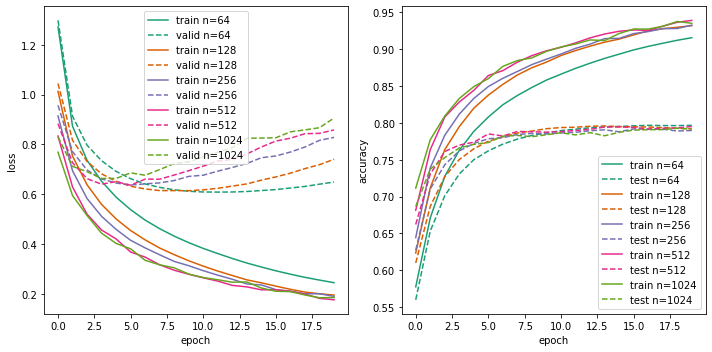

In [ ]:
fig,axes=plt.subplots(1,2)
fig.set_size_inches(10.0,5.0)
colors = cm.Dark2.colors
for color,n in zip(colors,df["n"].unique()):
    dfn = df3[df3["n"]==n]
    x = dfn["epoch"]
    ax = axes[0]
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x,dfn["train_loss"],label=f"train n={n}",color=color)
    ax.plot(x,dfn["valid_loss"],label=f"valid n={n}",color=color,linestyle='--')
    ax.legend()
    ax = axes[1]
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.plot(x,dfn["train_accu"],label=f"train n={n}",color=color)
    ax.plot(x,dfn["valid_accu"],label=f"test n={n}",color=color,linestyle='--')
    ax.legend()
fig.tight_layout()
plt.show()    

In [ ]:
df4 = df3.pivot_table(index=["n"],
                    aggfunc={
                        "train_loss":min,
                        "valid_loss":min,
                        "train_accu":max,
                        "valid_accu":max,
                    }
                   ).reset_index()
df4

,n,train_accu,train_loss,valid_accu,valid_loss
0,64,0.915736,0.245513,0.796736,0.608977
1,128,0.932069,0.195817,0.795847,0.614684
2,256,0.932792,0.190644,0.791861,0.637478
3,512,0.939264,0.176729,0.795125,0.636826
4,1024,0.937792,0.185117,0.792764,0.663631


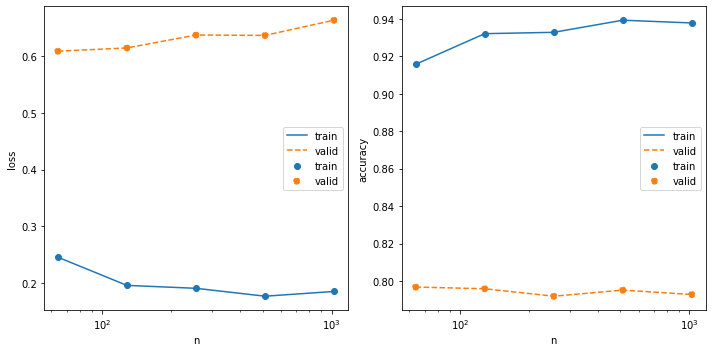

In [ ]:
x=df4["n"]
fig,axes=plt.subplots(1,2)
fig.set_size_inches(10.0,5.0)
ax = axes[0]
ax.set_xlabel("n")
ax.set_ylabel("loss")
ax.scatter(x,df4["train_loss"],label=f"train")
ax.plot(x,df4["train_loss"],label=f"train")
ax.scatter(x,df4["valid_loss"],label=f"valid",linestyle='--')
ax.plot(x,df4["valid_loss"],label=f"valid",linestyle='--')
ax.set_xscale("log")
#ax.set_yscale("log")
ax.legend()
ax = axes[1]
ax.set_xlabel("n")
ax.set_ylabel("accuracy")
ax.scatter(x,df4["train_accu"],label=f"train")
ax.plot(x,df4["train_accu"],label=f"train")
ax.scatter(x,df4["valid_accu"],label=f"valid",linestyle='--')
ax.plot(x,df4["valid_accu"],label=f"valid",linestyle='--')
ax.set_xscale("log")
ax.legend()
fig.tight_layout()
plt.show()    

In [ ]:
%%bash --out list_json
# Usamos el bash magic de Jupyter para ver que archivos *.json hemos creado.
# Guardamos el resultado en la variable list_json
ls *.json

In [ ]:
# De la variable, creamos una lista de archivos .json
list_json = list_json.split()
list_json

['simulation-results-2022-02-19-23-37-13.json']

In [ ]:
# Hacemos lista de archivos json que nos interese
json_fname_list = list_json
json_fname_list

['simulation-results-2022-02-19-23-37-13.json']

In [ ]:
# Cargamos varios archivos json como DataFrame's y los unificamos en un solo DataFrame
df_list = []
for json_fname in json_fname_list:
    df_list.append(pd.read_json(json_fname))
df = pd.concat(df_list,axis=0)
df

,n,k,epoch,train_loss,train_accu,valid_loss,valid_accu
0,64,0,0,1.238002,0.625,1.262854,0.592
1,64,0,1,0.849886,0.695,0.855370,0.683
2,64,0,2,0.721000,0.738,0.748251,0.718
3,64,0,3,0.638531,0.773,0.685374,0.753
4,64,0,4,0.574242,0.796,0.640220,0.768
...,...,...,...,...,...,...,...
7195,1024,71,15,0.262431,0.902,0.790435,0.775
7196,1024,71,16,0.203088,0.931,0.783955,0.778
7197,1024,71,17,0.180758,0.935,0.758385,0.785
7198,1024,71,18,0.165165,0.938,0.758172,0.792


#K-FOLD

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import sklearn as skl
import pandas as pd
#from torchviz import make_dot
import torch.optim as optim
from collections import defaultdict
import pickle
import dill
import json
import datetime
from sklearn.model_selection import KFold
try:
    import google.colab
    from google.colab import files  
    COLAB = True
except:
    COLAB = False

train_dataset=train_dataset_all

In [ ]:
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer,verbose_each=32):  
    # Calculamos cosas utiles que necesitamos
    num_samples = len(dataloader.dataset)
    # Seteamos el modelo en modo entrenamiento. Esto sirve para activar, por ejemplo, dropout, etc. durante la fase de entrenamiento.
    model.train()
    # Pasamos el modelo la GPU si está disponible.        
    model = model.to(device)    
    # Iteramos sobre lotes (batchs)
    for batch,(X,y) in enumerate(dataloader):
        # Pasamos los tensores a la GPU si está disponible.
        X = X.to(device)
        y = y.to(device)      
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso cada 100 batchs
        if batch % verbose_each*len(X) == 0:
            loss   = loss.item()
            sample = batch*len(X) # Número de batch * número de muestras en cada batch
            #print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{sample:>5d}/{num_samples:>5d}]")            
# De manera similar, definimos la función de validación y testeo
def test_loop(dataloader,model,loss_fn):
    num_samples  = 0
    num_batches  = 0
    avrg_loss    = 0
    frac_correct = 0
    # Seteamos el modelo en modo evaluacion. Esto sirve para desactivar, por ejemplo, dropout, etc. cuando no estamos en una fase de entrenamiento.
    model.eval()
    # Pasamos el modelo la GPU si está disponible.    
    model = model.to(device)    
    # Para validar, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Pasamos los tensores a la GPU si está disponible.
            X = X.to(device)
            y = y.to(device)           
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            avrg_loss += loss_fn(pred,y).item()
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            num_batches += 1
            num_samples += y.size(0)
            frac_correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avrg_loss    /= num_batches
    frac_correct /= num_samples
    #print(f"Test Error: \n Accuracy: {frac_correct:>0.5f}, Avg. loss: {avrg_loss:>8f} \n")
    return avrg_loss,frac_correct

In [ ]:
# Definimos hiperparámetros de entrenamiento
init_datetime = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
learning_rate = 1e-3
batch_size = 1000
max_epochs = 25
num_k = 6
# Creamos un DataFrame de pandas para ir almacenando los valores calculados.
df = pd.DataFrame()
# Creamos una funcion de perdida
loss_fn = nn.CrossEntropyLoss()
# Creamos el generador de k-folds
kfold = KFold(n_splits=num_k,shuffle=False)
# Simulamos por tramos porque google colab se desconecta antes de que concluya para todos los valores de n en la lista.
min_valid_loss = 10000000.0
max_valid_accu = 0.0
for k,(train_ids,valid_ids) in enumerate(kfold.split(train_dataset)):
    # Creamos los dataloaders de entrenamiento y validacion
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler=train_subsampler)
    valid_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,sampler=valid_subsampler)
    # Creamos el modelo
    model = Net(128)
    # Creamos el optimizador
    #optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)
    # Entrenamos el modelo, calcualmos y almacenamos valores de metricas obtenidos
    min_valid_loss = float("inf")
    for epoch in range(max_epochs):
        train_loop(train_loader,model,loss_fn,optimizer)
        train_loss,train_accu = test_loop(train_loader,model,loss_fn)
        valid_loss,valid_accu = test_loop(valid_loader,model,loss_fn)
        print(f"k={k} epoch={epoch} train_loss={train_loss} train_accu={train_accu} valid_loss={valid_loss} valid_accu={valid_accu}")
        df = df.append({"k":k,
                        "epoch":epoch,
                        "train_loss":train_loss,
                        "train_accu":train_accu,
                        "valid_loss":valid_loss,
                        "valid_accu":valid_accu}
                        ,ignore_index=True)
        if min_valid_loss > valid_loss: # or max_valid_accu < valid_accu:
            if min_valid_loss > valid_loss:
                min_valid_loss = valid_loss
            if max_valid_accu < valid_accu:
                max_valid_accu = valid_accu
            # Guardamos los parámetros del modelo.
            model_fname = "kfold-best-model-"+init_datetime+".ptm"
            print("   Saving model_fname =",model_fname,end="")
            print(" ... DONE!")
            torch.save(model.state_dict(),model_fname)
json_fname = "kfold-simulation-results-"+init_datetime+".json"
df.to_json(json_fname)
if COLAB:
    files.download(model_fname)
    files.download(json_fname)

k=0 epoch=0 train_loss=0.651803447008133 train_accu=0.77294 valid_loss=0.6560326635837554 valid_accu=0.7755
   Saving model_fname = kfold-best-model-2022-02-21-23-15-12.ptm ... DONE!
k=0 epoch=1 train_loss=0.4983491587638855 train_accu=0.82338 valid_loss=0.5065218478441238 valid_accu=0.8219
   Saving model_fname = kfold-best-model-2022-02-21-23-15-12.ptm ... DONE!
k=0 epoch=2 train_loss=0.4446482300758362 train_accu=0.8449 valid_loss=0.4557215392589569 valid_accu=0.8407
   Saving model_fname = kfold-best-model-2022-02-21-23-15-12.ptm ... DONE!
k=0 epoch=3 train_loss=0.41639704585075377 train_accu=0.85444 valid_loss=0.430586114525795 valid_accu=0.8495
   Saving model_fname = kfold-best-model-2022-02-21-23-15-12.ptm ... DONE!
k=0 epoch=4 train_loss=0.3950593554973602 train_accu=0.86028 valid_loss=0.4102658212184906 valid_accu=0.8568
   Saving model_fname = kfold-best-model-2022-02-21-23-15-12.ptm ... DONE!
k=0 epoch=5 train_loss=0.3783270364999771 train_accu=0.8666 valid_loss=0.393680757

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%bash --out list_json
# Usamos el bash magic de Jupyter para ver que archivos *.json hemos creado.
# Guardamos el resultado en la variable list_json
ls *.json

In [ ]:
list_json = list_json.split()
list_json

['kfold-simulation-results-2022-02-21-23-15-12.json']

In [ ]:
df = pd.concat([pd.read_json(json_fname) for json_fname in list_json],ignore_index=True)
df

,k,epoch,train_loss,train_accu,valid_loss,valid_accu
0,0,0,0.651803,0.77294,0.656033,0.7755
1,0,1,0.498349,0.82338,0.506522,0.8219
2,0,2,0.444648,0.84490,0.455722,0.8407
3,0,3,0.416397,0.85444,0.430586,0.8495
4,0,4,0.395059,0.86028,0.410266,0.8568
...,...,...,...,...,...,...
145,5,20,0.269483,0.90220,0.339794,0.8798
146,5,21,0.285481,0.89676,0.353279,0.8754
147,5,22,0.267347,0.90316,0.344650,0.8772
148,5,23,0.257998,0.90698,0.329968,0.8822


In [ ]:
# Eliminamos la columna "k" que indexa los folds.
df1 = df.drop("k",1)
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,epoch,train_loss,train_accu,valid_loss,valid_accu
0,0,0.651803,0.77294,0.656033,0.7755
1,1,0.498349,0.82338,0.506522,0.8219
2,2,0.444648,0.84490,0.455722,0.8407
3,3,0.416397,0.85444,0.430586,0.8495
4,4,0.395059,0.86028,0.410266,0.8568
...,...,...,...,...,...
145,20,0.269483,0.90220,0.339794,0.8798
146,21,0.285481,0.89676,0.353279,0.8754
147,22,0.267347,0.90316,0.344650,0.8772
148,23,0.257998,0.90698,0.329968,0.8822


In [ ]:
# Contamos cuantas muestras hay en cada metrica por cada epoca
df2 = df1.pivot_table(index=["epoch"],aggfunc="count").reset_index()
df2

,epoch,train_accu,train_loss,valid_accu,valid_loss
0,0,6,6,6,6
1,1,6,6,6,6
2,2,6,6,6,6
3,3,6,6,6,6
4,4,6,6,6,6
5,5,6,6,6,6
6,6,6,6,6,6
7,7,6,6,6,6
8,8,6,6,6,6
9,9,6,6,6,6


In [ ]:
# Para epoca, calculamos el promedio de cada metrica sobre muestras
df3 = df1.pivot_table(index=["epoch"],aggfunc="mean").reset_index()
df3

,epoch,train_accu,train_loss,valid_accu,valid_loss
0,0,0.763467,0.650623,0.763300,0.652095
1,1,0.824203,0.506862,0.820867,0.513073
2,2,0.842807,0.451839,0.839717,0.460367
3,3,0.851340,0.425261,0.847767,0.436674
4,4,0.858910,0.401828,0.854217,0.416997
5,5,0.864937,0.384197,0.858750,0.401891
6,6,0.867073,0.376159,0.860700,0.396290
7,7,0.873130,0.359407,0.866033,0.382385
8,8,0.876420,0.349967,0.868367,0.374656
9,9,0.878470,0.344949,0.868733,0.372311


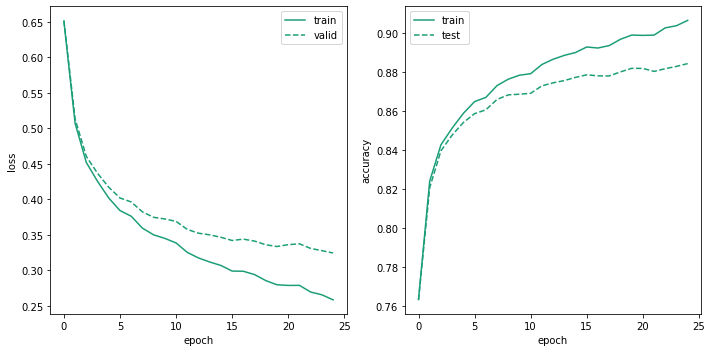

In [ ]:
fig,axes=plt.subplots(1,2)
fig.set_size_inches(10.0,5.0)
colors = cm.Dark2.colors
for color in colors[:1]:
    x = df3["epoch"]
    ax = axes[0]
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.plot(x,df3["train_loss"],label=f"train",color=color)
    ax.plot(x,df3["valid_loss"],label=f"valid",color=color,linestyle='--')
    ax.legend()
    ax = axes[1]
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.plot(x,df3["train_accu"],label=f"train",color=color)
    ax.plot(x,df3["valid_accu"],label=f"test",color=color,linestyle='--')
    ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
%%bash --out model_fname
# Usamos el bash magic de Jupyter para ver que archivos *.json hemos creado.
# Guardamos el resultado en la variable list_json
ls *.ptm

In [ ]:
model_fname = model_fname.split()[0]

In [ ]:
model_forward = Net(128)
model_forward.load_state_dict(torch.load(model_fname,map_location="cpu"))
model_forward.eval()
model_forward = model_forward.to(device)

In [ ]:
batch_size = 1000
loss_fn = nn.CrossEntropyLoss()
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)
test_loss,test_accu = test_loop(test_loader,model,loss_fn)
print("test_loss = ",test_loss)
print("test_accu = ",test_accu)

test_loss =  0.35066538751125337
test_accu =  0.8766


In [ ]:
model_fname='kfold-best-model-forward-128neuronas-2022-02-21-23-15-12.ptm'
model_forward = Net(128)
model_forward.load_state_dict(torch.load(model_fname,map_location="cpu"))
model_forward.eval()
model_forward = model_forward.to(device)
batch_size = 1000
loss_fn = nn.CrossEntropyLoss()
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)
test_loss,test_accu = test_loop(test_loader,model_forward,loss_fn)
print("test_loss = ",test_loss)
print("test_accu = ",test_accu)

test_loss =  0.3506653726100922
test_accu =  0.8766


In [ ]:
from torch.nn.functional import softmax
from random import randint
def plot_img(data, idx):
    """
    Grafica un ejemplo
    """
    figure = plt.figure(figsize=(4, 4))
    img, label = data[idx]
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

def show_prediction(example,model):
    """
    Muestra la predicción para un ejemplo
    """
    model.eval()
    x, y = test_dataset[example][0], test_dataset[example][1]
    with torch.no_grad():
        pred = model(x.unsqueeze(1).to(device))
    sorted = pred.sort()
    values = softmax(sorted.values[0], dim=-1)
    indices = sorted.indices[0]
    print(
        f'Etiqueta correcta: {labels_map[y]}', 
        end='\n----------------\n'
    )
    print('Etiqueta     Probabilidad')
    for v, idx in list(zip(values,indices))[::-1]:
        label_pred = labels_map[idx.item()]
        print(f'{label_pred:13}{v.item():.5f}')

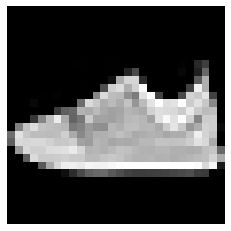

Etiqueta correcta: Sneaker
----------------
Etiqueta     Probabilidad
Sneaker      0.96985
Ankle Boot   0.01769
Sandal       0.01238
Bag          0.00008
Shirt        0.00000
Coat         0.00000
Dress        0.00000
Pullover     0.00000
T-Shirt      0.00000
Trouser      0.00000


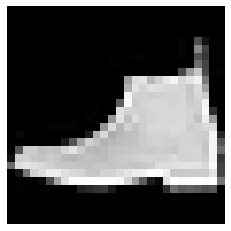

Etiqueta correcta: Ankle Boot
----------------
Etiqueta     Probabilidad
Ankle Boot   0.99990
Sneaker      0.00010
Sandal       0.00000
Shirt        0.00000
Bag          0.00000
T-Shirt      0.00000
Pullover     0.00000
Coat         0.00000
Dress        0.00000
Trouser      0.00000


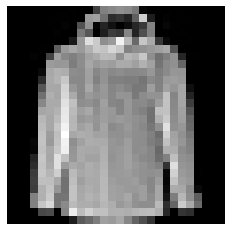

Etiqueta correcta: Coat
----------------
Etiqueta     Probabilidad
Coat         0.94264
Bag          0.03233
Pullover     0.02409
Shirt        0.00047
T-Shirt      0.00038
Dress        0.00008
Trouser      0.00001
Sneaker      0.00000
Sandal       0.00000
Ankle Boot   0.00000


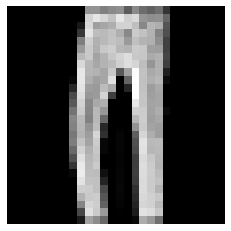

Etiqueta correcta: Trouser
----------------
Etiqueta     Probabilidad
Trouser      0.99997
T-Shirt      0.00002
Dress        0.00001
Coat         0.00000
Pullover     0.00000
Shirt        0.00000
Bag          0.00000
Sneaker      0.00000
Ankle Boot   0.00000
Sandal       0.00000


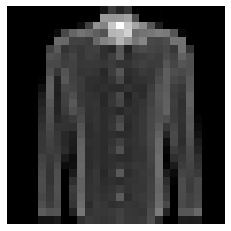

Etiqueta correcta: Shirt
----------------
Etiqueta     Probabilidad
Shirt        0.85755
Coat         0.08223
Pullover     0.05364
T-Shirt      0.00491
Dress        0.00105
Bag          0.00054
Sandal       0.00004
Trouser      0.00003
Ankle Boot   0.00000
Sneaker      0.00000


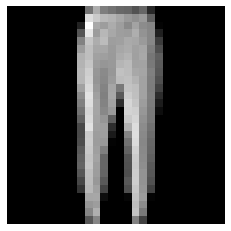

Etiqueta correcta: Trouser
----------------
Etiqueta     Probabilidad
Trouser      0.99969
Dress        0.00016
T-Shirt      0.00011
Coat         0.00002
Pullover     0.00001
Shirt        0.00001
Sneaker      0.00000
Bag          0.00000
Ankle Boot   0.00000
Sandal       0.00000


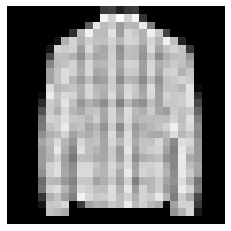

Etiqueta correcta: Shirt
----------------
Etiqueta     Probabilidad
Coat         0.81423
Shirt        0.09683
Pullover     0.08793
Bag          0.00091
T-Shirt      0.00009
Dress        0.00001
Trouser      0.00000
Ankle Boot   0.00000
Sneaker      0.00000
Sandal       0.00000


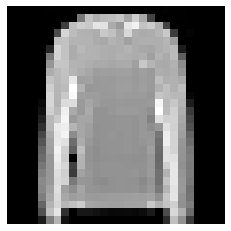

Etiqueta correcta: Pullover
----------------
Etiqueta     Probabilidad
Pullover     0.79459
Coat         0.11082
Shirt        0.09424
T-Shirt      0.00027
Bag          0.00006
Dress        0.00002
Trouser      0.00000
Sandal       0.00000
Sneaker      0.00000
Ankle Boot   0.00000


In [ ]:
example = randint(1,10000)
plot_img(test_dataset, example)
show_prediction(example,model_forward)

example = randint(1,10000)
plot_img(test_dataset, example)
show_prediction(example,model_forward)

example = randint(5000,10000)
plot_img(test_dataset, example)
show_prediction(example,model_forward)

example = randint(5000,10000)
plot_img(test_dataset, example)
show_prediction(example,model_forward)

example = randint(1,10000)
plot_img(test_dataset, example)
show_prediction(example,model_forward)

example = randint(1,10000)
plot_img(test_dataset, example)
show_prediction(example,model_forward)

example = randint(5000,10000)
plot_img(test_dataset, example)
show_prediction(example,model_forward)

example = randint(5000,10000)
plot_img(test_dataset, example)
show_prediction(example,model_forward)